<a href="https://colab.research.google.com/github/ersilia-os/ersilia-intro-workshop/blob/main/notebooks/m3_hdac1_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDAC1 inhibition

This notebook shows the steps to clean up a dataset obtained from ChEMBL target 325 and train a machine learning model based on that data.

_This notebook is prepared to run locally when clonning this repository, if you want to run it in Colab please make sure to add the datasets on Colab and redirect the paths as needed_

## 1. Data Cleaning

We download the whole dataset from ChEMBL as a zip file and extract the .csv as chembl325.csv

In [ ]:
import os
import pandas as pd
from standardiser import standardise
from rdkit import Chem

DATAPATH = "../data/m3_datasets/hdac1"

In [ ]:
df = pd.read_csv(os.path.join(DATAPATH, "original", "chembl325.csv"))

#we keep all rows that have a pChEMBL value
df = df[df["pChEMBL Value"].notnull()]

#and standardise the SMILES to obtain its canonical form
std_smiles = []
for smi in df["Smiles"].tolist():
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = standardise.run(mol)
        smi = Chem.MolToSmiles(mol)
    except:
        smi = None
    std_smiles += [smi]

df["std_smiles"] = std_smiles

# any row for which we cannot get the SMILES is eliminated
df = df[df["std_smiles"].notnull()]

In [ ]:
# we finally save the processed dataset
result = df.groupby('Molecule ChEMBL ID').agg(
    SMILES=('std_smiles', 'first'),
    pIC50=('pChEMBL Value', 'median')
).reset_index()
result.to_csv(os.path.join(DATAPATH, "processed", "hdac1_chembl325.csv"), index=False)

## 2. Train an AI model

This notebook contains the basic steps to train a classifier for bioactivity prediction.

It is prepared to run on Google Colaboratory, if you want to run it locally make sure to create a conda environment with Python 3.10 and install the packages indicated below.

_Remember that the ! sign indicates a bash command, to run it in the terminal simply copy the command without !_

In [ ]:
# Package installation if notebook is run in Colab
!pip install lazyqsar==0.3

### 2.1 Load your data

Next, we will use the pandas package to load the training data. At the bare minimmum, you should have a .csv file with two columns: SMILES and Activity of the molecule against the desired target.

In Google Colab, go to the left hand side of the screen and click on the `folder` icon. There, you will see a `Upload file` icon to add your files to the Cloud. You can also call them from Google Drive. These files will be deleted if the notebook is closed, so you will need to re-upload them every time.

If you are working locally, just make sure to input the right path to your data file.

In [ ]:
import os
import pandas as pd
import numpy as np
import lazyqsar as lq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [16]:
#make sure to input the right path to your data

filename = "hdac1_chembl325.csv" 
DATAPATH = "../data/m3_datasets/hdac1"
MODELPATH = "../models"
FIGUREPATH = "../figures/m3"

In [17]:
# Load data into a Pandas DataFrame (df)
# We will use the read_csv function from Pandas to automatically upload the csv file in the right format for Python

df = pd.read_csv(os.path.join(DATAPATH, "processed", filename))
df.columns

Index(['Molecule ChEMBL ID', 'SMILES', 'pIC50'], dtype='object')

In [18]:
# and its shape
df.shape

(5804, 3)

In [19]:
# Let's get the variables right!
# If the column name changes, you need to change these variables
# Remember Python strings are case-sensitive
SMILES = "SMILES"
EXP = "pIC50"
BIN = "bin"

### 2.2 Define a cut-off

Since we will create a classifier, we need to decide at which cut-off we consider our molecules `Active` or `Inactive`.

We can visualise our data with a histogram for example to make the decision, or we can ask the original data producers for their expert recommendation.

(array([1.000e+00, 1.650e+02, 6.280e+02, 1.023e+03, 1.286e+03, 1.301e+03,
        8.590e+02, 3.700e+02, 1.480e+02, 2.300e+01]),
 array([ 3.2 ,  3.91,  4.62,  5.33,  6.04,  6.75,  7.46,  8.17,  8.88,
         9.59, 10.3 ]),
 <BarContainer object of 10 artists>)

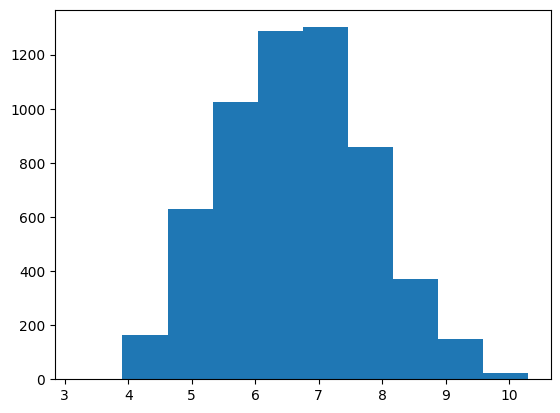

In [20]:
# We select the variable we want to plot in the histogram, in this case the activity values
x = df[EXP] #here you need to write the exact column name, respecting Caps
# We now plot the data using the histogram function
plt.hist(x)

Text(0, 0.5, 'Number of mols')

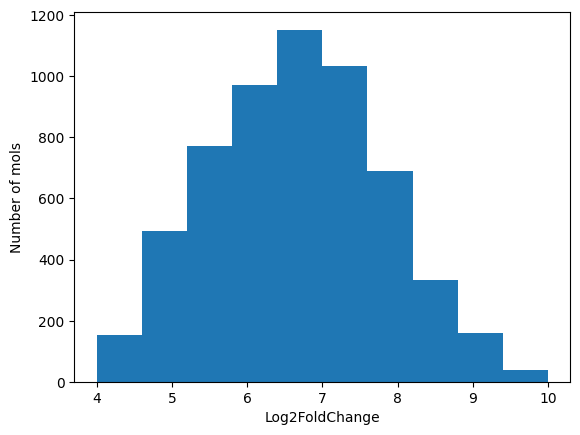

In [21]:
# Depending on our data, we might want to improve the plot for better visualization
# here, we clip the maximmum values to 20
plt.hist(x, range=(4, 10))
plt.xlabel("Log2FoldChange")
plt.ylabel("Number of mols")

To identify the best activity cut-off for your data, you need to:
- Understand the experimental set up: what kind of assay was done? what is the units of activity measured?
- Understand what is the end goal for the model: is it obtaining the most active compounds? Is it to filter our some non-actives to reduce the test number?
- Ask the experts! Talk to the people who ran the experiment, if possible

Once you have the cut-off, transform the activities to binary. Typically, by consensus:
- 1: Active (the compound perturbs our biological system)
- 0: Inactive (the compound does not affect our biolgical system)

In [22]:
cutoff = 7
direction = "higher"

In [24]:
# Here, we will create a new column in our file with the binary activity

if direction == "lower":
    df[BIN] = [1 if x <= cutoff else 0 for x in df[EXP]]
elif direction == "higher":
    df[BIN] = [1 if x >= cutoff else 0 for x in df[EXP]]
else:
    print("no direction specified. Please select lower or higher direction for the activity cut-off")

In [25]:
# Let's check the output
df

,Molecule ChEMBL ID,SMILES,pIC50,bin
0,CHEMBL100035,C/C(=C\c1ccc(NS(=O)(=O)c2ccccc2)cc1)C(=O)NO,5.70,0
1,CHEMBL1076794,Cc1ccccc1NC(=O)CCCCC(=O)NO,6.24,0
2,CHEMBL1076939,COc1cc(-n2cc(-c3cccc(NC(=O)CCCCCCC(=O)NO)c3)nn...,8.30,1
3,CHEMBL1080580,Cc1ccc(NC(=O)c2ccc(/C=C/C(=O)NO)cc2)cc1Nc1nc(-...,7.10,1
4,CHEMBL1082955,O=C(CCCCCNC(=O)NC(=O)c1ccc(-c2cncnc2)cc1)NO,6.29,0
...,...,...,...,...
5799,CHEMBL99398,Nc1ccccc1NC(=O)CCCCCN1C(=O)c2cccc3cc(O)cc(c23)...,6.00,0
5800,CHEMBL99456,O=C(CCCCCCC(=O)c1ccc(-c2ccc(Br)cc2)cc1)NO,8.70,1
5801,CHEMBL99671,COc1ccc(C(=O)CCCCCCC(=O)Nc2ccccc2N)cc1,5.30,0
5802,CHEMBL99810,O=C(CCCCCCCC(=O)c1ccccc1)NO,6.87,0


In [26]:
# We can print how many actives / inactives we have in our dataset
print("Total molecules: ", len(df))
print("Active molecules: ", len(df[df[BIN]==1]))
print("Inactive molecules: ", len(df[df[BIN]==0]))
print("Frequency of Actives (%): ", len(df[df[BIN]==1])/len(df)*100)

Total molecules:  5804
Active molecules:  2260
Inactive molecules:  3544
Frequency of Actives (%):  38.938662991040665


### 2.3 Divide the data into Train and Test sets

To make sure our model will have good performance, we need to keep part of the data as a test set, to evaluate the model once trained.

Typically, it is good practice to reserve ~20% of the data as test set. Make sure that the balance of actives / inactives is maintained both in the train and the test sets.

We will try a 5-fold cross-validation (run 5 times random train-test split sets and evaluate the different model performances)

In [27]:
# We will use this function to split the data
# The function uses the sklearn train_test_split built-in method

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df[SMILES], df[EXP], indices, test_size=size, stratify=df[BIN])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

In [28]:
for i in range(5):
    train, test = random_split(df, 0.2)
    train.to_csv(os.path.join(DATAPATH,"train_test_splits", "train_bin7_set_{}.csv".format(i)), index=False)
    test.to_csv(os.path.join(DATAPATH,"train_test_splits","test_bin7_set_{}.csv".format(i)), index=False)

In [29]:
# We can make sure the active / inactive balance was preserved
train_balance = len(train[train[BIN]==1])/len(train)*100
test_balance = len(test[test[BIN]==1])/len(test)*100

print("The frequency of Actives in the train set is: ", train_balance)
print("The frequency of Actives in the test set is: ", test_balance)

The frequency of Actives in the train set is:  38.940340297221624
The frequency of Actives in the test set is:  38.93195521102498


_* We have individually created the descriptors so that we can check how they look like. Luckily, LazyQSAR provides a single funtion to convert the smiles to vectors and train an ML model, so we will use that feature_

### 2.4 Train an ML model & get the predictions with Morgan Fingerprints

We have our input (morgan descriptors) and the endpoint, the activity in binary format (1 or 0) so we are ready to train a classifier!
We will use the built-in method in LazyQSAR

In [30]:
%%capture

for i in range(5):
    train = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","train_bin7_set_{}.csv".format(i)))
    test = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","test_bin7_set_{}.csv".format(i)))
    smiles_train = train[SMILES]
    y_train = train[BIN]
    model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(train[SMILES], train[BIN])
    y_hat = model.predict_proba(test[SMILES])
    test["proba1"] = y_hat[:,1]
    test.to_csv(os.path.join(DATAPATH,"train_test_splits","test_set_pred_bin7_morgan_{}.csv".format(i)))

#### The ROC-AUC curve

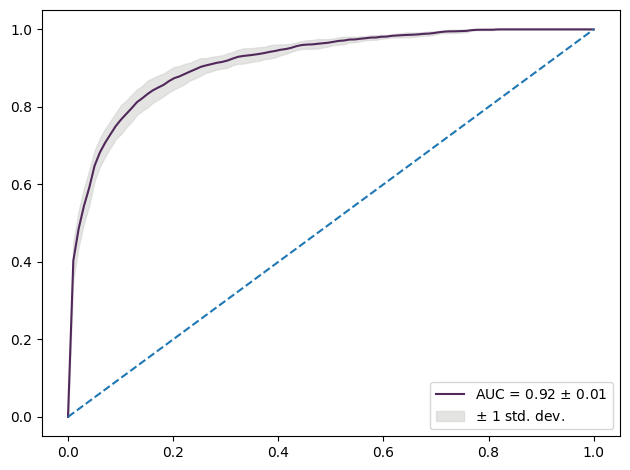

In [33]:
fig, ax = plt.subplots(1,1)

aucs = []
tprs = []
mean_fpr = np.linspace(0,1,100)
for i in range(5):
    test = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","test_set_pred_bin7_morgan_{}.csv".format(i)))
    fpr, tpr, _ = metrics.roc_curve(test[BIN],test["proba1"])
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="#50285a",
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
ax.plot([0, 1], [0, 1], ls="--")
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#d2d2d0",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
ax.legend(loc="lower right")
ax.set_xlabel="1-Specificity (FPR)",
ax.set_ylabel="Sensitivity (TPR)",
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, "roc_hdac1_bin7_morgan.png"), dpi=300)

### 2.5 Train an ML Model with Ersilia Compound Embeddings

In [34]:
%%capture

for i in range(5):
    train = pd.read_csv(os.path.join(DATAPATH,"hdac1","train_bin7_set_{}.csv".format(i)))
    test = pd.read_csv(os.path.join(DATAPATH,"hdac1","test_bin7_set_{}.csv".format(i)))
    smiles_train = train[SMILES]
    y_train = train[BIN]
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(train[SMILES], train[BIN])
    y_hat = model.predict_proba(test[SMILES])
    test["proba1"] = y_hat[:,1]
    test.to_csv(os.path.join(DATAPATH,"hdac1","test_set_bin7_pred_eosce_{}.csv".format(i)))

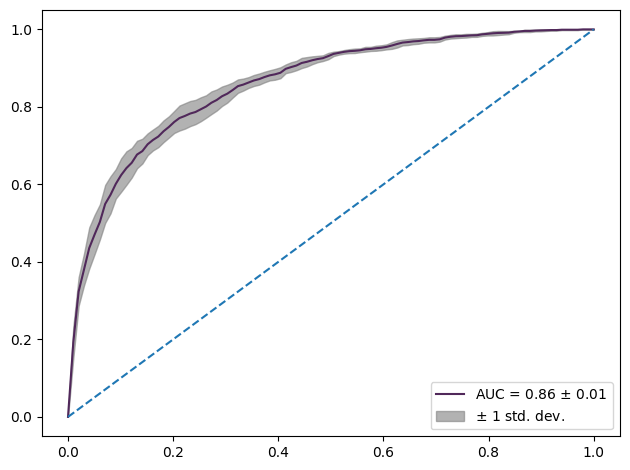

In [37]:
fig, ax = plt.subplots(1,1)

aucs = []
tprs = []
mean_fpr = np.linspace(0,1,100)
for i in range(5):
    test = pd.read_csv(os.path.join(DATAPATH, "train_test_splits","test_set_pred_bin7_eosce_{}.csv".format(i)))
    fpr, tpr, _ = metrics.roc_curve(test[BIN],test["proba1"])
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="#50285a",
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
ax.plot([0, 1], [0, 1], ls="--")
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="gray",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
ax.legend(loc="lower right")
ax.set_xlabel="1-Specificity (FPR)",
ax.set_ylabel="Sensitivity (TPR)",
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, "roc_hdac1_bin7_eosce.png"), dpi=300)

### 2.6 Save the final model

To ensure we use all possible data, at the end of the pipeline we will train the model with the whole dataset (train and test) and save it as the final model for deployment.

We need to choose which descriptor and parameters will work better for our case and build the model accordingly. We obtain that from the best train-test experiment.

In [38]:
# train the model with the full data
smiles_train = df[SMILES]
y_train = df[BIN]
model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
model.fit(smiles_train, y_train)
model.save(os.path.join(MODELPATH,"hdac1_bin7_morgan_model.joblib"))

`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecate

### 2.7 Get a second cut-off

To have more fine-grain predictive potential, we will also build a second model with a more restrictive cut-off of pIC50=8

In [ ]:
#make sure to input the right path to your data

filename = "hdac1_chembl325.csv" 
DATAPATH = "../data/hdac1"
MODELPATH = "../models"
FIGUREPATH = "../figures"

In [43]:
df = pd.read_csv(os.path.join(DATAPATH, "processed",filename))
df.shape

(5804, 3)

In [44]:
cutoff = 8
direction = "higher"
if direction == "lower":
    df[BIN] = [1 if x <= cutoff else 0 for x in df[EXP]]
elif direction == "higher":
    df[BIN] = [1 if x >= cutoff else 0 for x in df[EXP]]
else:
    print("no direction specified. Please select lower or higher direction for the activity cut-off")

# We can print how many actives / inactives we have in our dataset
print("Total molecules: ", len(df))
print("Active molecules: ", len(df[df[BIN]==1]))
print("Inactive molecules: ", len(df[df[BIN]==0]))
print("Frequency of Actives (%): ", len(df[df[BIN]==1])/len(df)*100)

Total molecules:  5804
Active molecules:  747
Inactive molecules:  5057
Frequency of Actives (%):  12.870434183321846


In [45]:
for i in range(5):
    train, test = random_split(df, 0.2)
    train.to_csv(os.path.join(DATAPATH,"train_test_splits", "train_bin8_set_{}.csv".format(i)), index=False)
    test.to_csv(os.path.join(DATAPATH,"train_test_splits","test_bin8_set_{}.csv".format(i)), index=False)
# We can make sure the active / inactive balance was preserved
train_balance = len(train[train[BIN]==1])/len(train)*100
test_balance = len(test[test[BIN]==1])/len(test)*100

print("The frequency of Actives in the train set is: ", train_balance)
print("The frequency of Actives in the test set is: ", test_balance)

The frequency of Actives in the train set is:  12.879603704501399
The frequency of Actives in the test set is:  12.833763996554696


In [46]:
%%capture

for i in range(5):
    train = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","train_bin8_set_{}.csv".format(i)))
    test = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","test_bin8_set_{}.csv".format(i)))
    smiles_train = train[SMILES]
    y_train = train[BIN]
    model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(train[SMILES], train[BIN])
    y_hat = model.predict_proba(test[SMILES])
    test["proba1"] = y_hat[:,1]
    test.to_csv(os.path.join(DATAPATH,"train_test_splits","test_set_pred_bin8_morgan_{}.csv".format(i)))

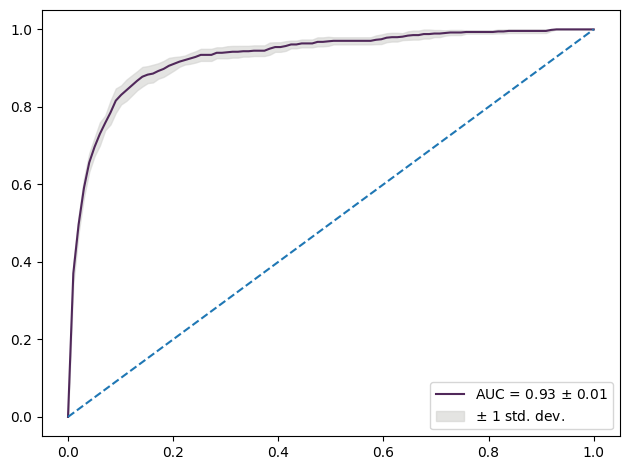

In [47]:
fig, ax = plt.subplots(1,1)

aucs = []
tprs = []
mean_fpr = np.linspace(0,1,100)
for i in range(5):
    test = pd.read_csv(os.path.join(DATAPATH,"train_test_splits","test_set_pred_bin8_morgan_{}.csv".format(i)))
    fpr, tpr, _ = metrics.roc_curve(test[BIN],test["proba1"])
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
        mean_fpr,
        mean_tpr,
        color="#50285a",
        label=r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
    )
ax.plot([0, 1], [0, 1], ls="--")
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="#d2d2d0",
    alpha=0.6,
    label=r"$\pm$ 1 std. dev.",
    )
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        )
ax.legend(loc="lower right")
ax.set_xlabel="1-Specificity (FPR)",
ax.set_ylabel="Sensitivity (TPR)",
plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, "roc_hdac1_bin8_morgan.png"), dpi=300)

In [48]:
# train the model with the full data
smiles_train = df[SMILES]
y_train = df[BIN]
model = lq.MorganBinaryClassifier(time_budget_sec=60, estimator_list=["rf", "lgbm", "xgboost"])
model.fit(smiles_train, y_train)
model.save(os.path.join(MODELPATH,"hdac1_bin8_morgan_model.joblib"))

`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecate